# Classificando tipos de anemia
Este notebook tem como objetivo desenvolver um modelo de classificação de anemia utilizando técnicas de Machine Learning. Através da análise de dados de exames de sangue, o modelo será capaz de identificar o tipo de anemia presente em cada paciente.

## Importação e Pré-processamento dos Dados:

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [6]:
df = pd.read_csv('data/diagnosed_cbc_data_v4.csv')
df.head()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


* Verificando se existem valores ausentes

In [7]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap="plasma")

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
df.dtypes

WBC          float64
LYMp         float64
NEUTp        float64
LYMn         float64
NEUTn        float64
RBC          float64
HGB          float64
HCT          float64
MCV          float64
MCH          float64
MCHC         float64
PLT          float64
PDW          float64
PCT          float64
Diagnosis     object
dtype: object

In [9]:
df.describe()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT
count,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.0000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000
mean,7.862717,25.845000,77.511000,1.880760,5.140940,4.708267,12.184551,46.1526,85.793919,32.084840,31.739149,229.981421,14.312512,0.260280
std,3.564466,7.038728,147.746273,1.335689,2.872294,2.817200,3.812897,104.8861,27.177663,111.170756,3.300352,93.019336,3.005079,0.685351
min,0.800000,6.200000,0.700000,0.200000,0.500000,1.360000,-10.000000,2.0000,-79.300000,10.900000,11.500000,10.000000,8.400000,0.010000
25%,6.000000,25.845000,71.100000,1.880760,5.100000,4.190000,10.800000,39.2000,81.200000,25.500000,30.600000,157.000000,13.300000,0.170000
50%,7.400000,25.845000,77.511000,1.880760,5.140940,4.600000,12.300000,46.1526,86.600000,27.800000,32.000000,213.000000,14.312512,0.260280
75%,8.680000,25.845000,77.511000,1.880760,5.140940,5.100000,13.500000,46.1526,90.200000,29.600000,32.900000,293.000000,14.700000,0.260280
max,45.700000,91.400000,5317.000000,41.800000,79.000000,90.800000,87.100000,3715.0000,990.000000,3117.000000,92.800000,660.000000,97.000000,13.600000


* Removendo dados duplicados

In [10]:
df.duplicated().sum()

49

In [11]:
df = df.drop_duplicates()
df.duplicated().sum()

0

* Numerando variáveis categóricas

In [12]:
mapping_dict = {}


encoder = LabelEncoder()
encoded_data = encoder.fit_transform(df['Diagnosis'])
mapping_dict['Diagnosis'] = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
df['Diagnosis'] = encoded_data
df['Diagnosis'].value_counts()



0    323
5    271
6    255
1    184
8     72
7     56
2     44
4     16
3     11
Name: Diagnosis, dtype: int64

In [13]:
mapping_dict

{'Diagnosis': {0: 'Healthy',
  1: 'Iron deficiency anemia',
  2: 'Leukemia',
  3: 'Leukemia with thrombocytopenia',
  4: 'Macrocytic anemia',
  5: 'Normocytic hypochromic anemia',
  6: 'Normocytic normochromic anemia',
  7: 'Other microcytic anemia',
  8: 'Thrombocytopenia'}}

{'Diagnosis': {0: 'Healthy',
  1: 'Iron deficiency anemia',
  2: 'Leukemia',
  3: 'Leukemia with thrombocytopenia',
  4: 'Macrocytic anemia',
  5: 'Normocytic hypochromic anemia',
  6: 'Normocytic normochromic anemia',
  7: 'Other microcytic anemia',
  8: 'Thrombocytopenia'}}

### Analisando os dados

* Gráfico de frequencia dos diagnosticos.

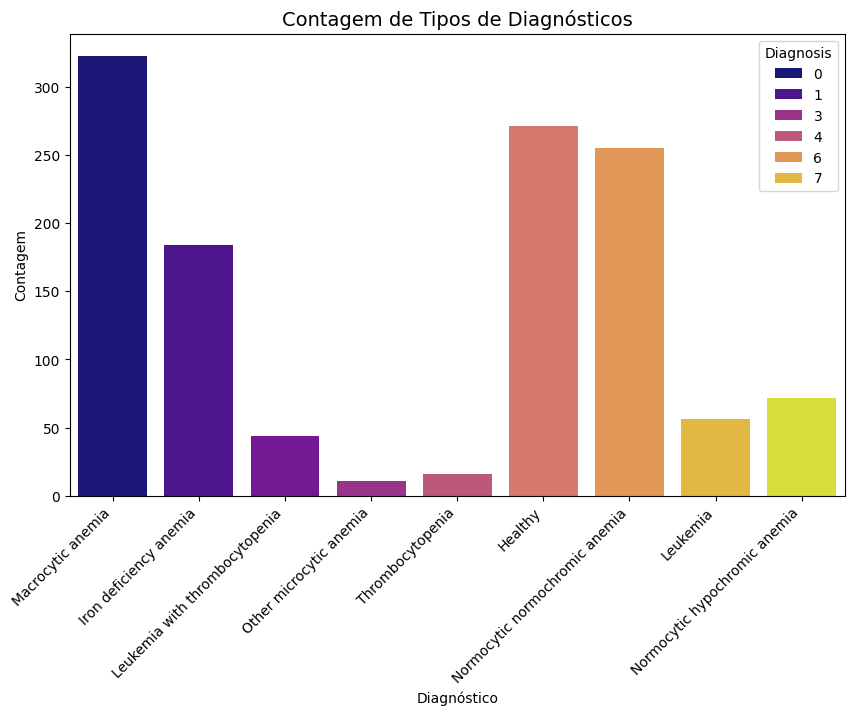

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Diagnosis', data=df,hue='Diagnosis', palette='plasma')

plt.title('Contagem de Tipos de Diagnósticos', fontsize=14)
ax.set_xticks(df['Diagnosis'].unique())
ax.set_xticklabels(labels=mapping_dict['Diagnosis'].values(), rotation=45, horizontalalignment='right')
ax.set_ylabel('Contagem', fontsize=10)
ax.set_xlabel('Diagnóstico', fontsize=10)

plt.show()

* Histograma de distribuição dos dados

In [198]:
def plot_distribution_grid(df, columns, bins=10):
    """
    Cria uma grade de histogramas com Kernel Density Estimation (KDE) para visualização da distribuição de múltiplas colunas.
    
    Args:
      df (pandas.DataFrame): DataFrame contendo os dados.
      columns (list): Lista de nomes das colunas a serem exibidas no histograma.
          (default: None)
      bins (int): Número de bins (intervalos) utilizados no histograma.
          (default: 10) 
    """
    num_rows = len(columns) // 3 + (1 if len(columns) % 3 != 0 else 0)
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    for i, column in enumerate(columns):
        row = i // num_cols
        col = i % num_cols
        sns.histplot(df[column], kde=True, bins=bins, ax=axes[row, col], color="blue")
        axes[row, col].set_title(f'Distribuição de {column}')
    
    # Remover subplots não utilizados
    for i in range(len(columns), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

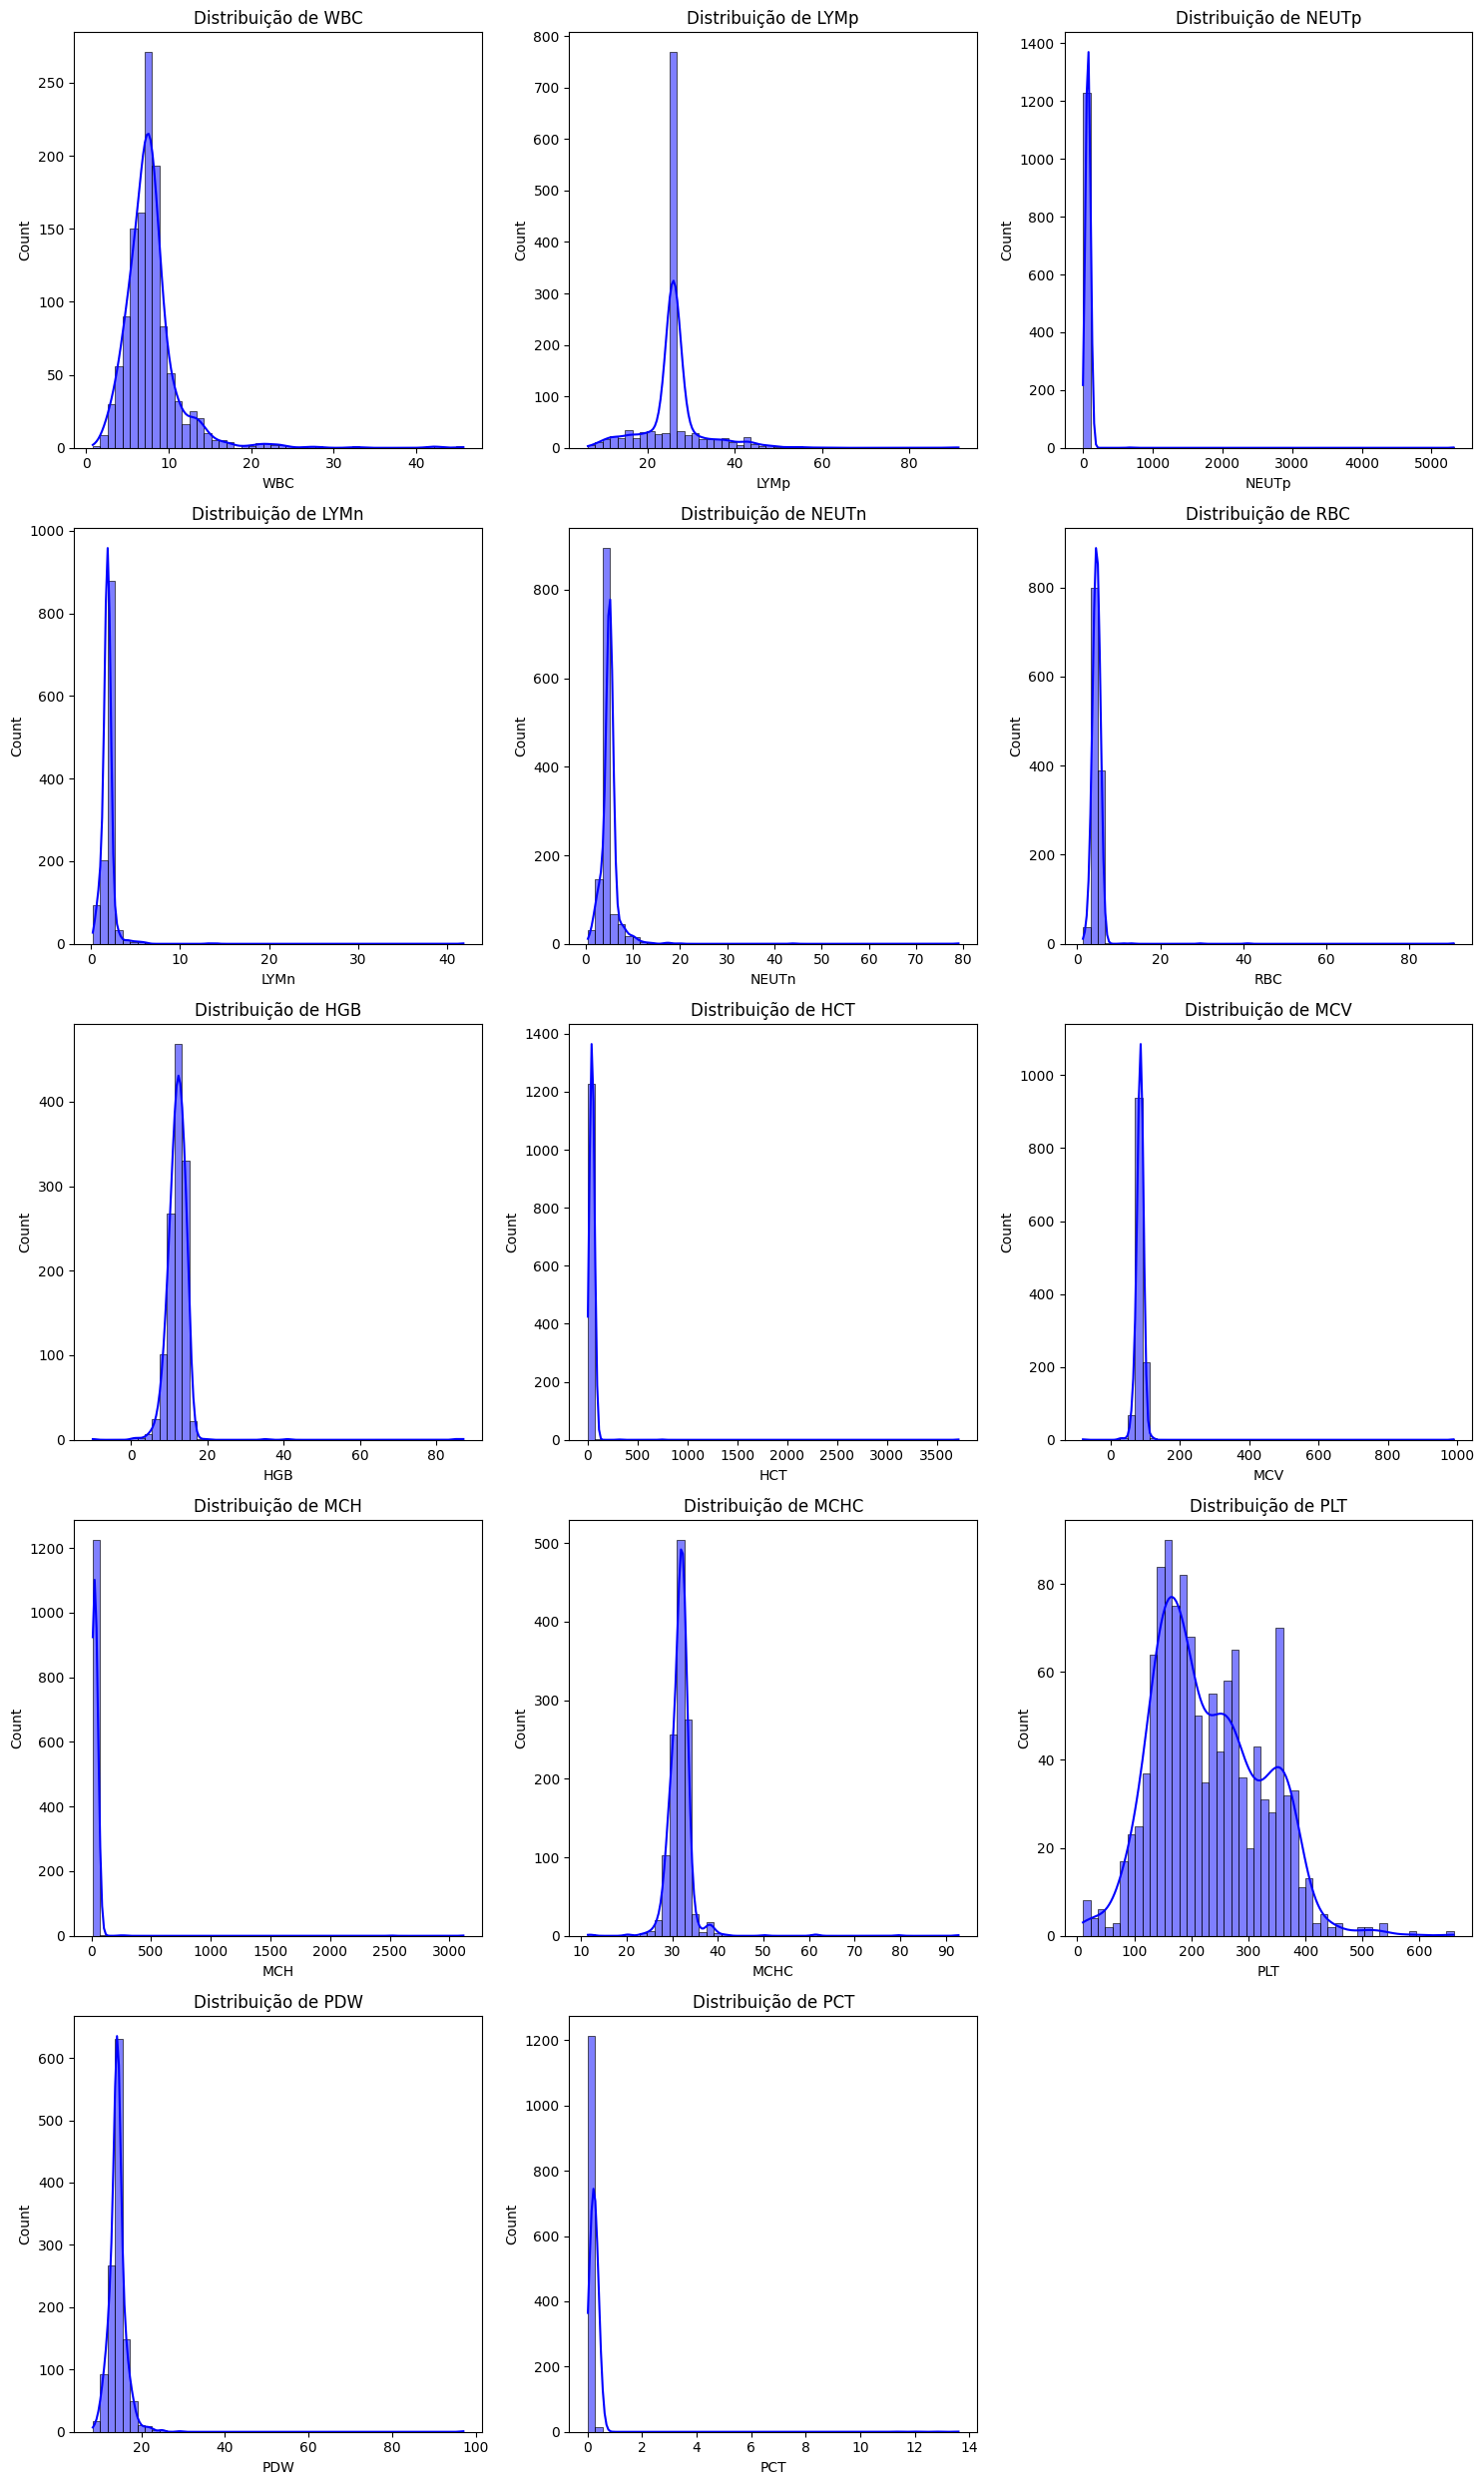

In [199]:
columns = df.columns.to_list()
columns.remove('Diagnosis')
plot_distribution_grid(df, columns, bins=50)

* Boxplot para identificar outliers

In [200]:
def plot_boxplot_grid(df, columns):
  """
  Cria uma grade de boxplots para visualização da distribuição de múltiplas colunas.

  Args:
      df (pandas.DataFrame): DataFrame contendo os dados.
      columns (list): Lista de nomes das colunas a serem exibidas no boxplot.
  """

  num_rows = len(columns) // 3 + (1 if len(columns) % 3 != 0 else 0)
  num_cols = 3
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

  for i, column in enumerate(columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(
        x = df[column],
        ax = axes[row, col],
        color="blue"
    )
    axes[row, col].set_title(f'Boxplot de {column}')

  # Remover subplots não utilizados
  for i in range(len(columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

  plt.tight_layout()
  plt.show()


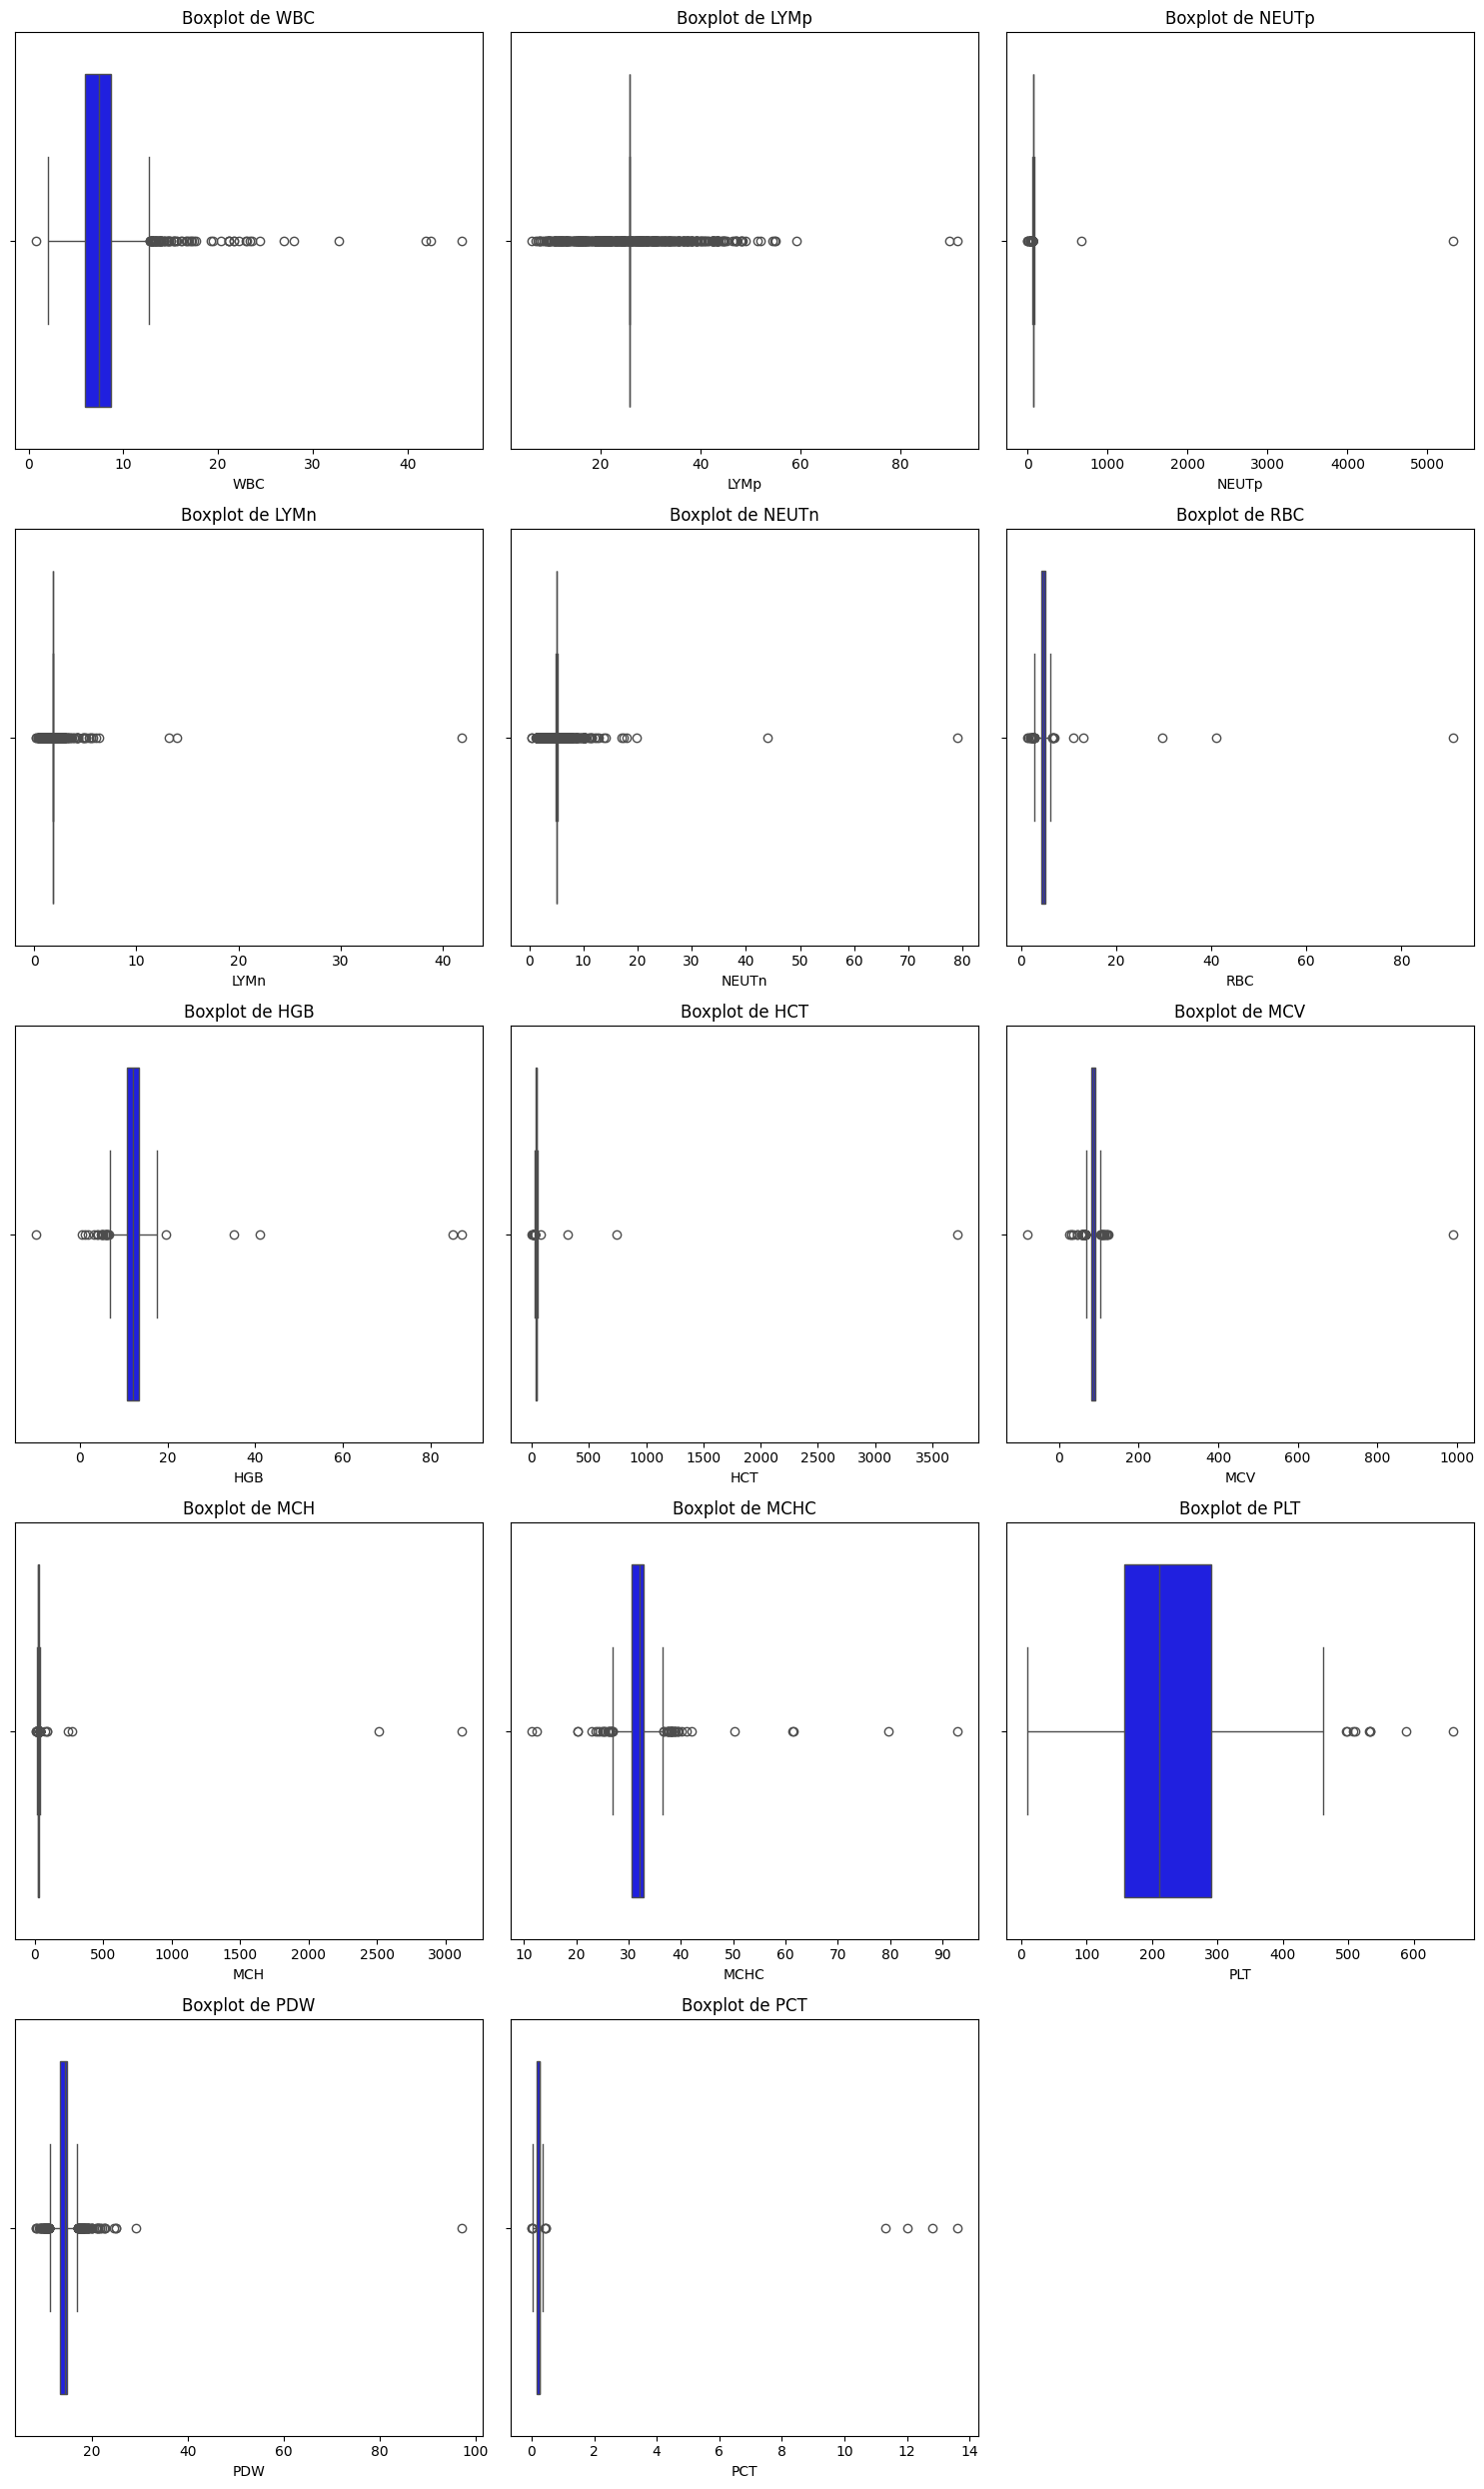

In [201]:
plot_boxplot_grid(df, columns)

* Os dados apresentam desvio padrão alto e alguns outliers.
* Matriz de correlação

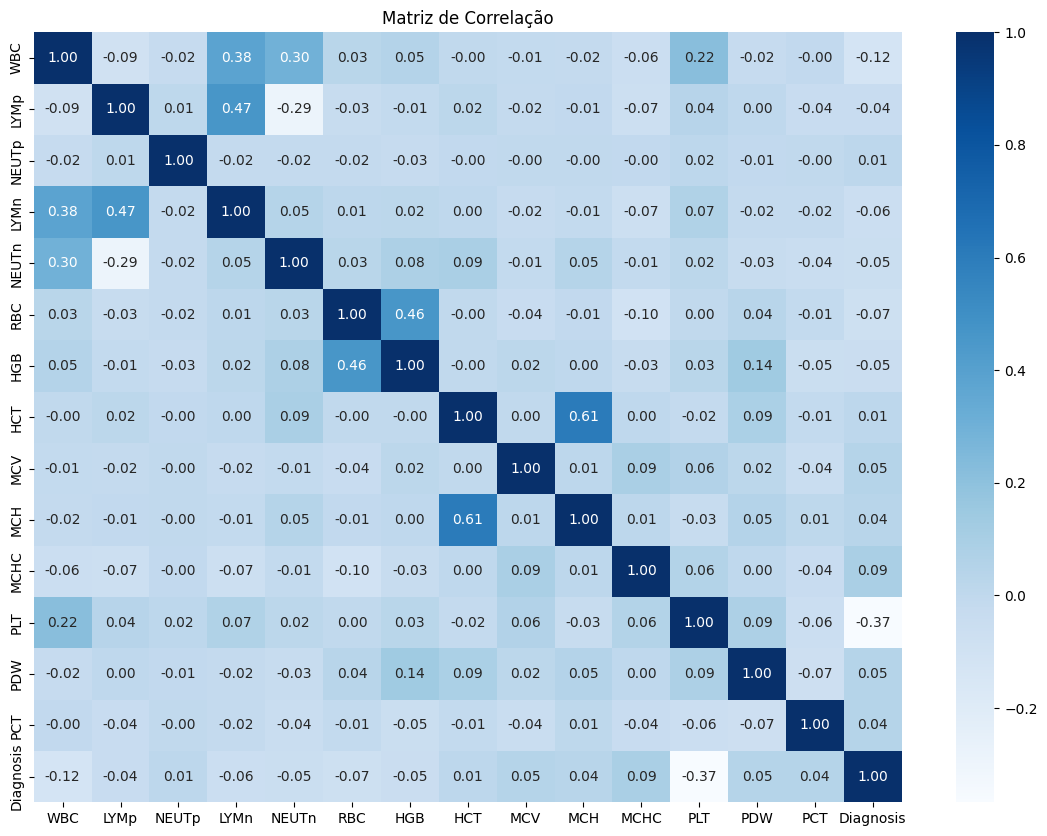

In [202]:
correlation_matrix = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()
plt.close()

In [203]:
def dist_for_each_anamemia_type(df, columns, target, path, bins=10):
    colors = ['blue', 'red', 'green', 'magenta', 'yellow', 'cyan', 'white', 'black', 'gray']
    num_rows = len(columns) // 3 + (1 if len(columns) % 3 != 0 else 0)
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    df_filtered = df[df['Diagnosis'] == target]
    
    for i, column in enumerate(columns):
        row = i // num_cols
        col = i % num_cols
        sns.histplot(df_filtered[column], kde=True, bins=bins, ax=axes[row, col], color=colors[target])
        axes[row, col].set_title(f'Distribuição de {column}')
    
    # Remover subplots não utilizados
    for i in range(len(columns), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.savefig(path + f"Dist{target}.png")

In [204]:
#targets = df["Diagnosis"].unique()

#columns = df.columns.to_list()
#columns.remove('Diagnosis')

#for target in targets:
#    dist_for_each_anamemia_type(df, columns, target, "./assets/distributions/", bins=50)

In [205]:
def check_outliers_std(dataframe, col_name):
    outliers_indexes = []

    upper_boundary = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 3 * dataframe[col_name].std()
    outliers_data = dataframe[(dataframe[col_name] > upper_boundary) | (dataframe[col_name] < lower_boundary)]

    for index, row in outliers_data.iterrows():
        outliers_indexes.append(index)

    return outliers_indexes

def remove_outliers(df):
    outliers_indexes = []

    for column in df.columns:
        outliers_out_fn = check_outliers_std(df, column)

        for index in outliers_out_fn:
            outliers_indexes.append(index)

    outliers_indexes = list(set(outliers_indexes))
    outliers_indexes.sort()
    
    new_data = df.drop(outliers_indexes)
    new_data.reset_index(drop=True, inplace=True)

    return new_data

def remove_outliers_from_column(df, column):
    outliers_out_fn = check_outliers_std(df, column)

    new_data = df.drop(outliers_out_fn)
    new_data.reset_index(drop=True, inplace=True)

    return new_data


In [206]:
df = remove_outliers(df)
df.shape

(1158, 15)

In [207]:
df.describe()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
count,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000,1158.000000
mean,7.527625,25.495462,73.504085,1.799143,5.007356,4.589430,12.120984,42.736809,85.580648,27.789525,31.707971,228.325907,14.269820,0.222359,3.417098
std,2.437102,5.829742,7.770957,0.464957,1.369267,0.705408,2.044281,5.651312,8.079974,10.373329,1.883603,88.903262,1.780310,0.058384,2.802879
min,0.800000,6.200000,30.400000,0.200000,1.200000,1.360000,1.200000,14.000000,44.900000,14.200000,22.900000,10.000000,8.400000,0.010000,0.000000
25%,6.000000,25.845000,71.500000,1.880760,5.140940,4.200000,10.800000,39.525000,81.500000,25.625000,30.700000,157.250000,13.300000,0.170000,0.000000
50%,7.400000,25.845000,77.511000,1.880760,5.140940,4.600000,12.300000,46.152600,86.750000,27.850000,32.000000,211.000000,14.312512,0.260280,5.000000
75%,8.500000,25.845000,77.511000,1.880760,5.140940,5.100000,13.500000,46.152600,90.300000,29.675000,32.975000,290.000000,14.800000,0.260280,6.000000
max,17.700000,47.000000,86.100000,5.600000,12.500000,6.900000,19.600000,53.300000,124.100000,275.000000,41.000000,499.000000,22.800000,0.440000,8.000000


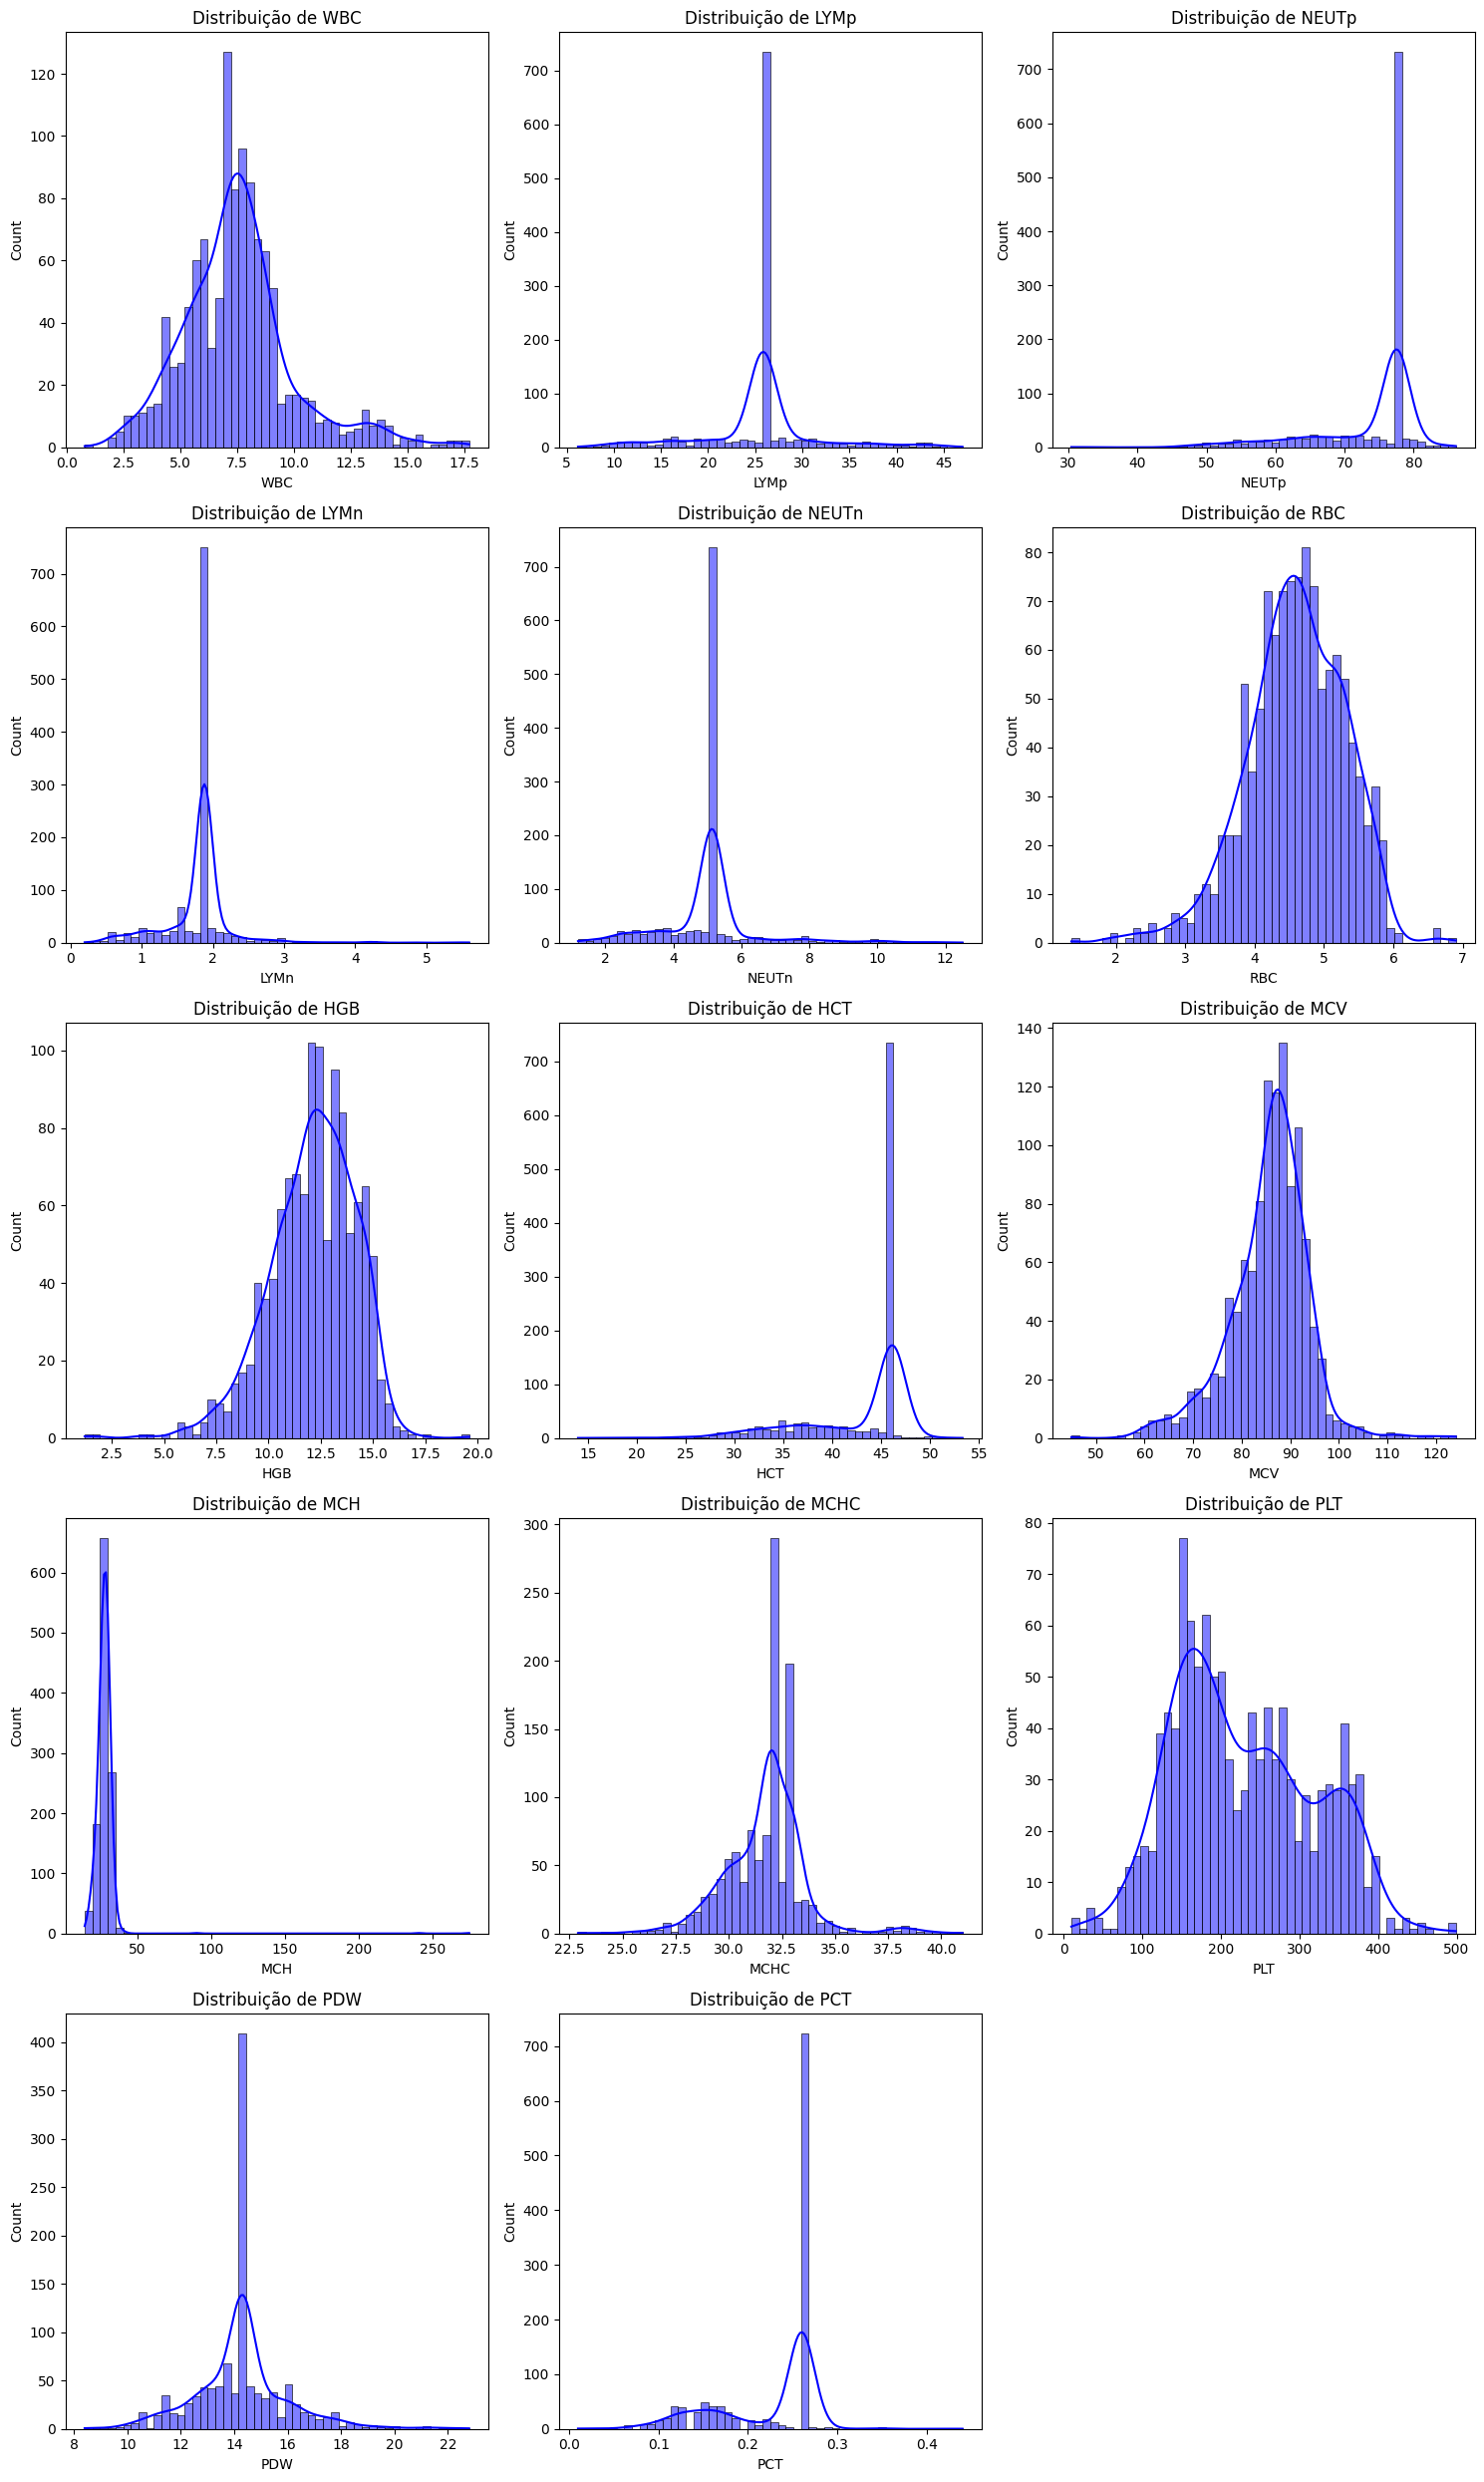

In [208]:
columns = df.columns.to_list()
columns.remove('Diagnosis')
plot_distribution_grid(df, columns, bins=50)

In [209]:
data = pd.read_csv('data/diagnosed_cbc_data_v4.csv')

In [210]:
df["Diagnosis"].unique()

array([5, 1, 2, 0, 8, 6, 7, 3, 4])

In [211]:
mapping_dict = {}


encoder = LabelEncoder()
encoded_data = encoder.fit_transform(data['Diagnosis'])
mapping_dict['Diagnosis'] = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
data['Diagnosis'] = encoded_data

mapping_dict

{'Diagnosis': {0: 'Healthy',
  1: 'Iron deficiency anemia',
  2: 'Leukemia',
  3: 'Leukemia with thrombocytopenia',
  4: 'Macrocytic anemia',
  5: 'Normocytic hypochromic anemia',
  6: 'Normocytic normochromic anemia',
  7: 'Other microcytic anemia',
  8: 'Thrombocytopenia'}}

In [222]:
dict = { 0: 'Healthy',
  1: 'Iron deficiency anemia',
  2: 'Leukemia',
  3: 'Leukemia with thrombocytopenia',
  4: 'Macrocytic anemia',
  5: 'Normocytic hypochromic anemia',
  6: 'Normocytic normochromic anemia',
  7: 'Other microcytic anemia',
  8: 'Thrombocytopenia'}

data["Diagnosis"] = data["Diagnosis"].replace(dict)
df["Diagnosis"] = df["Diagnosis"].replace(dict)

data["Diagnosis"].unique()

array(['Normocytic hypochromic anemia', 'Iron deficiency anemia',
       'Other microcytic anemia', 'Leukemia', 'Healthy',
       'Thrombocytopenia', 'Normocytic normochromic anemia',
       'Leukemia with thrombocytopenia', 'Macrocytic anemia'],
      dtype=object)

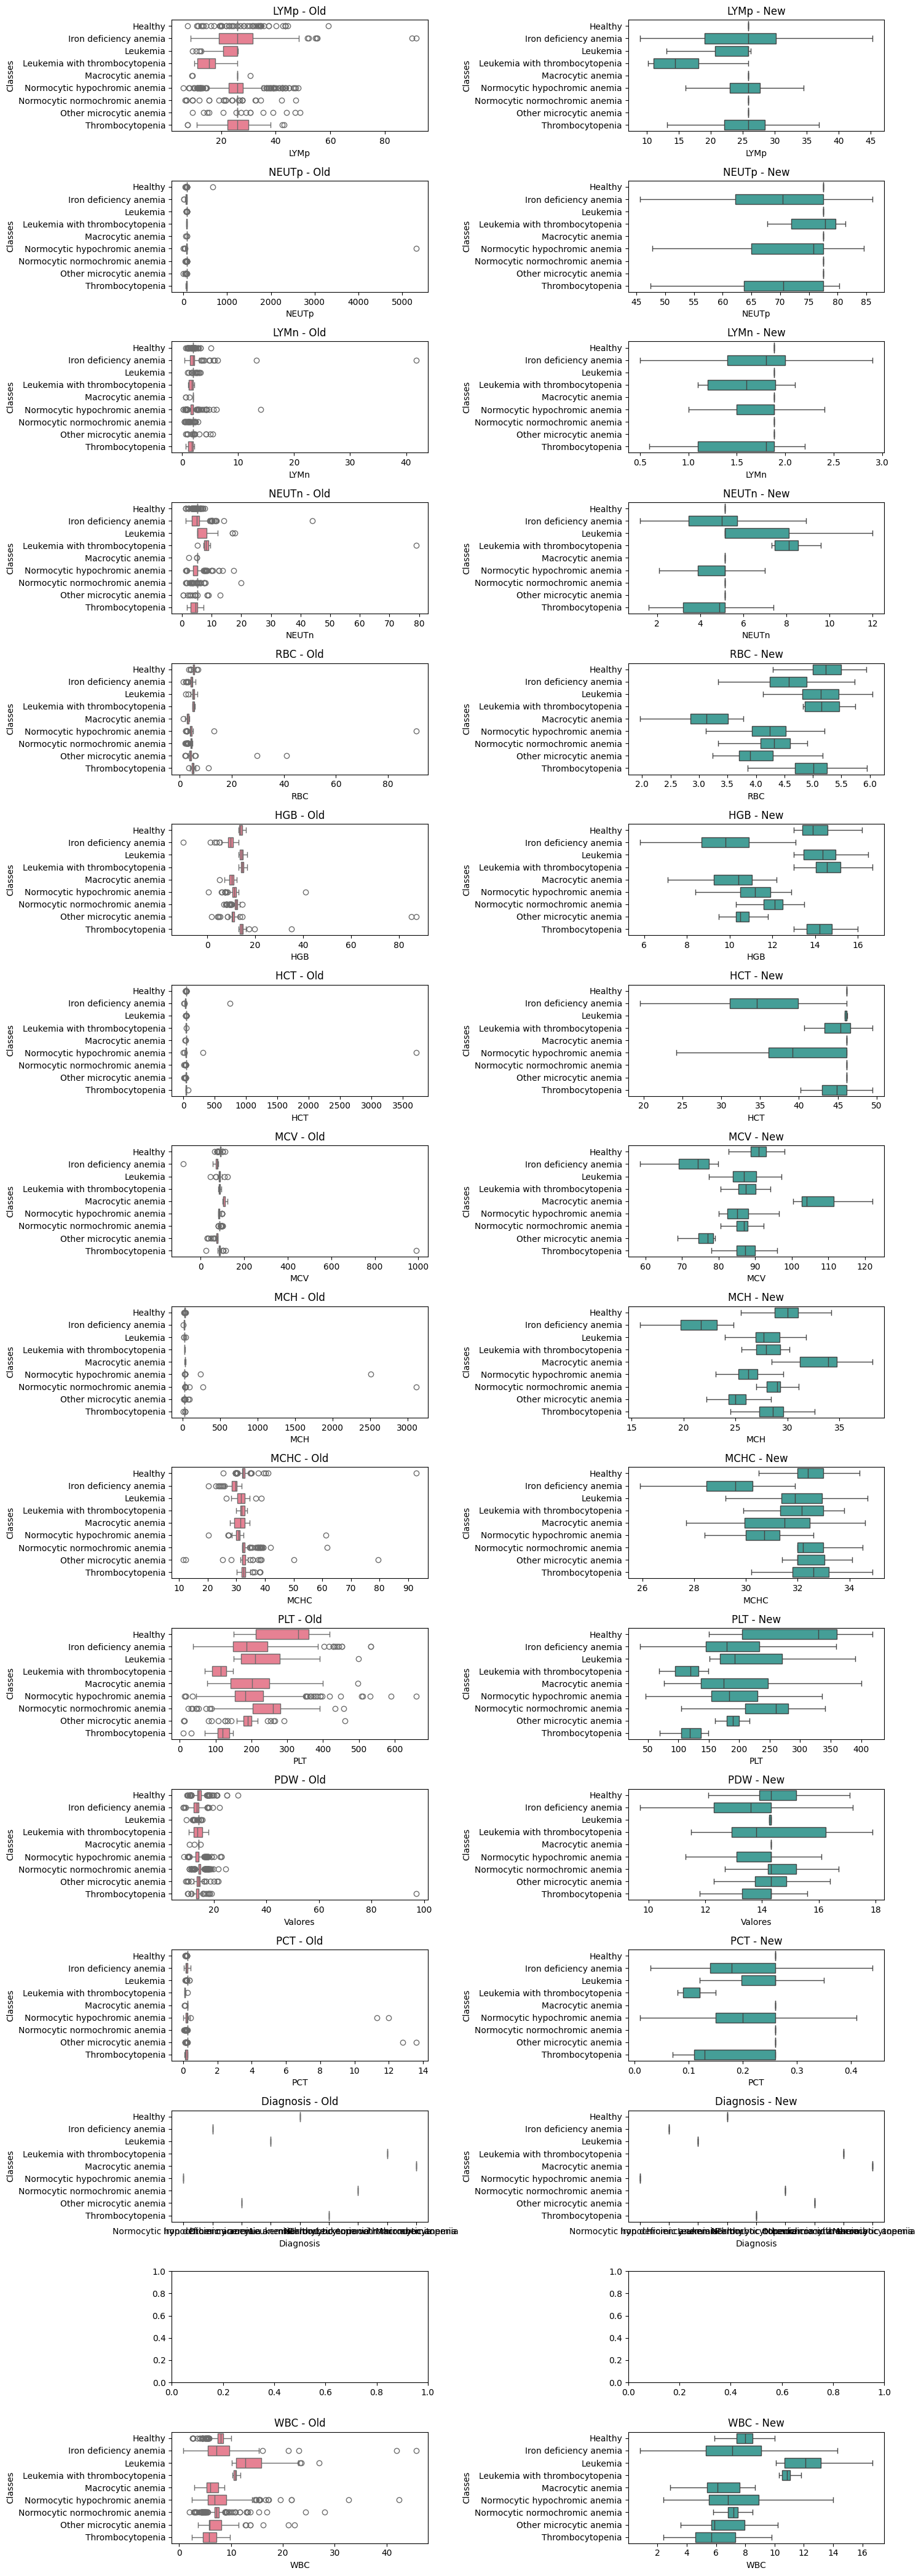

In [228]:
class_order = sorted(df['Diagnosis'].unique())

# Definir uma paleta de cores
palette = sns.color_palette("husl", n_colors=2)

# Criar boxplots horizontais para cada feature
fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(15, 3 * 14), sharex=False)

for i, feature in enumerate(df.columns):
    sns.boxplot(x=feature, y='Diagnosis', data=data, orient='h', ax=axes[i-1, 0], color=palette[0], order=class_order)
    sns.boxplot(x=feature, y='Diagnosis', data=df, orient='h', ax=axes[i-1, 1], color=palette[1], order=class_order, showfliers=False)
    
    axes[i-1, 0].set_title(f'{feature} - Old')
    axes[i-1, 1].set_title(f'{feature} - New')
    
    if i == 13 - 1:  # Only set xlabel for the last row
        axes[i-1, 0].set_xlabel('Valores')
        axes[i-1, 1].set_xlabel('Valores')
    
    axes[i-1, 0].set_ylabel('Classes')
    axes[i-1, 1].set_ylabel('Classes')

plt.tight_layout()
plt.savefig("./Boxplot_Before_After_Without_Outliers.png")
plt.close()

In [213]:
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, shuffle=True)

In [214]:
# Criar o pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Etapa de pré-processamento: padronização dos dados
    ('classifier', RandomForestClassifier(random_state=42))  # Etapa de modelagem: Random Forest
])

# Treinar o pipeline
pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = pipeline.predict(X_test)
#print("Previsões:", y_pred)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.9741379310344828


In [215]:
# Criar o pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Etapa de pré-processamento: padronização dos dados
    ('classifier', SVC(random_state=42))  # Etapa de modelagem: Support Vector Machine
])

# Treinar o pipeline
pipeline.fit(X_train, y_train)

# Fazer previsões
y_pred = pipeline.predict(X_test)
#print("Previsões:", y_pred)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)


Acurácia: 0.8333333333333334


In [216]:
# Criar um pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Etapa de pré-processamento: padronização dos dados
    ('classifier', RandomForestClassifier())  # Etapa de modelagem: classificador a ser determinado
])

# Definir a grade de parâmetros a serem testados
parameters = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10]
    }
]

# Realizar a busca de grade com validação cruzada
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_model = grid_search.best_estimator_

# Fazer previsões
y_pred = best_model.predict(X_test)
print("Previsões:", y_pred)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

# Parâmetros do melhor modelo
print("Melhores parâmetros:", grid_search.best_params_)

Previsões: [6 5 5 5 0 0 6 5 0 2 7 7 6 5 5 0 1 5 6 1 0 5 0 5 1 6 0 8 6 1 0 6 6 5 2 6 6
 5 5 6 0 5 0 1 6 0 0 8 1 6 5 0 8 6 5 8 0 6 6 1 2 5 6 5 0 6 1 0 6 8 0 1 5 4
 6 6 6 0 5 1 0 0 5 8 1 5 5 6 1 5 6 1 5 6 0 0 0 6 0 5 6 7 6 0 1 0 0 3 6 0 0
 5 6 2 6 0 0 0 3 0 0 5 1 0 6 1 0 5 5 1 0 8 0 0 6 0 6 0 2 0 0 1 6 5 0 3 0 8
 0 5 1 7 5 0 6 0 1 5 6 5 1 0 5 1 2 6 0 1 1 1 8 5 6 0 0 5 6 7 1 5 6 1 5 6 5
 5 8 5 1 1 6 0 5 3 5 0 0 0 0 6 0 8 1 1 0 7 6 0 6 5 5 5 2 1 2 0 5 1 8 0 1 1
 6 5 1 1 1 0 5 6 6 1 0 0 0 6 0 6 1 0 8 7 6 0 0 7 5 5 0 0 6 1 6 5 5 8 0 7 7
 6 8 5 6 0 6 6 0 5 1 6 1 1 1 5 6 5 8 0 5 0 0 5 1 5 8 2 5 1 8 8 0 5 8 0 6 1
 1 1 5 0 6 6 6 0 5 0 0 5 1 6 8 1 6 1 5 6 0 0 0 1 1 6 5 6 0 0 2 1 5 5 1 0 8
 0 0 0 0 6 8 0 6 1 5 0 0 5 1 0]
Acurácia: 0.9741379310344828
Melhores parâmetros: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 10, 'classifier__n_estimators': 200}


In [217]:
# Inicializar o classificador Naive Bayes Gaussiano
naive_bayes = GaussianNB()

# Treinar o modelo
naive_bayes.fit(X_train, y_train)

# Fazer previsões
y_pred = naive_bayes.predict(X_test)

# Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.7241379310344828


In [218]:
# Inicializar o classificador Gradient Boosting
gradient_boosting = GradientBoostingClassifier()

# Treinar o modelo
gradient_boosting.fit(X_train, y_train)

# Fazer previsões
y_pred = gradient_boosting.predict(X_test)

# Avaliar a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.9770114942528736


In [219]:
# Inicializar o classificador Random Forest
rf_classifier = GradientBoostingClassifier(random_state=43)

# Executar validação cruzada com 5 dobras
scores = cross_val_score(rf_classifier, X, y, cv=5)

# Imprimir as pontuações de validação cruzada
print("Acurácia em cada dobra:", scores)
print("Acurácia média:", scores.mean())

Acurácia em cada dobra: [0.96982759 0.99568966 0.99568966 0.92640693 0.98268398]
Acurácia média: 0.9740595611285267
